# Face Generation

In this project, I'll define and train a DCGAN on a dataset of faces. The goal is to get a generator network to generate *new* images of faces that look as realistic as possible!


### Get the Data

I'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train the adversarial networks.


### Pre-processed Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> You can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'


import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Visualize the CelebA Data


In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    transform = transforms.Compose([transforms.Resize(image_size), 
                                    transforms.ToTensor()]);
    
    data = datasets.ImageFolder(data_dir, transform=transform)
    
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                              shuffle = True)
    
    return data_loader


## Create a DataLoader


In [5]:
# Define function hyperparameters
batch_size = 128
img_size = 32

# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

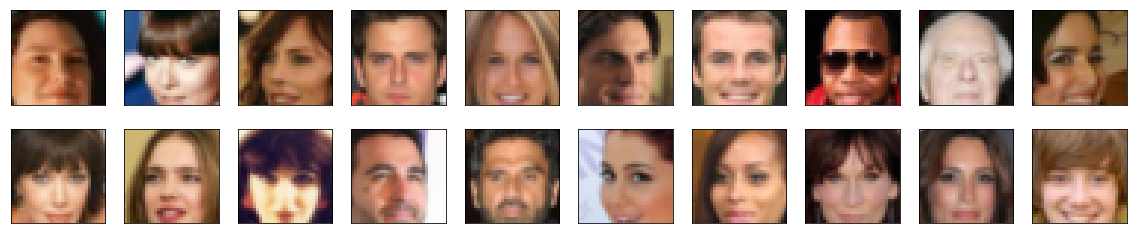

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Pre-process the image data and scale it to a pixel range of -1 to 1

We know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x*(max-min)+min
    return x


In [8]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(0.9137)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

First task will be to define the discriminator. This is a convolutional classifier, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. 



In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def conv(in_channels, out_channels, kernel_size= 5, stride=2, padding=2, batch_norm = True):
    
    layers = []
    conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias= not batch_norm)
    
    layers.append(conv)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv1 = conv(3, conv_dim)
        self.conv2 = conv(conv_dim, conv_dim*2)
        self.conv3 = conv(conv_dim*2, conv_dim*4)
        self.conv4 = conv(conv_dim*4, 1, kernel_size=4, stride =1, padding = 0, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # (32, 32, 3)
        x = F.leaky_relu(self.conv1(x), 0.2) # (16, 16, 128)
        x = F.leaky_relu(self.conv2(x), 0.2) # (8, 8, 256)
        x = F.leaky_relu(self.conv3(x), 0.2) # (4, 4, 512)
        x = self.conv4(x).view(-1, 1) # (1)
        return x



# tests.test_discriminator(Discriminator) # It was for testing locally

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.


In [12]:
def t_conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm = True):
    layers = []
    
    t_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias = not batch_norm)
    layers.append(t_conv)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim

        # complete init function
        self.fc = nn.Linear(z_size, 4*4*conv_dim*4)
        
        self.t_conv1 = t_conv(conv_dim*4, conv_dim*2)
        self.t_conv2 = t_conv(conv_dim*2, conv_dim)
        self.t_conv3 = t_conv(conv_dim, 3, batch_norm = False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        
        x = x.view(-1,self.conv_dim*4 , 4, 4 ) # (4, 4, 512)
        x = F.relu(self.t_conv1(x)) # (8, 8, 256)
        x = F.relu(self.t_conv2(x)) # (16, 16, 128)
        x = F.tanh(self.t_conv3(x)) # (32, 32, 3)
        
        return x

# tests.test_generator(Generator) # It was for testing locally

Tests Passed


## Initialize the weights of your networks

To help your models converge, it can be helpful to initialize the weights of the convolutional and linear layers in the model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.


In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Apply initial weights to convolutional and linear layers
    if classname.find("Conv2d") != -1 or classname.find("Linear") != -1:
        m.weight.data.normal_(0, 0.02)
        

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. 

In [15]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100


D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

### Training on GPU

Check if you can train on GPU. Here, I'll set this as a boolean variable `train_on_gpu`.


In [17]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Least Squares GANs

Binary cross entropy loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, I'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.



In [18]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out-1)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean(D_out**2)
    return loss

## Optimizers


In [19]:
import torch.optim as optim


d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

---
## Training

Training will involve alternating between training the discriminator and the generator. I'll use my functions `real_loss` and `fake_loss` to help me calculate the discriminator losses.


Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [21]:
def train(D, G, n_epochs, print_every=150):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            if train_on_gpu:
                real_images = real_images.cuda()

            # ===============================================
            #             TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            d_real_out = D(real_images)
            loss_real = real_loss(d_real_out)
            
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            g_out = G(z)
            d_fake_out = D(g_out)
            loss_fake = fake_loss(d_fake_out)
            
            d_loss = loss_real + loss_fake
            d_loss.backward()
            d_optimizer.step()
            
            
                

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            g_out = G(z)
            d_out = D(g_out)
            g_loss = real_loss(d_out)
            g_loss.backward()
            g_optimizer.step()
            

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Train GAN!

In [22]:
# set number of epochs 
n_epochs = 25


# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   25] | d_loss: 2.1699 | g_loss: 1.7654
Epoch [    1/   25] | d_loss: 0.2299 | g_loss: 2.1780
Epoch [    1/   25] | d_loss: 0.1364 | g_loss: 1.4792
Epoch [    1/   25] | d_loss: 0.2388 | g_loss: 0.7647
Epoch [    1/   25] | d_loss: 0.4165 | g_loss: 1.3853
Epoch [    2/   25] | d_loss: 0.2895 | g_loss: 0.4708
Epoch [    2/   25] | d_loss: 0.2471 | g_loss: 0.6257
Epoch [    2/   25] | d_loss: 0.3567 | g_loss: 0.5695
Epoch [    2/   25] | d_loss: 0.3330 | g_loss: 0.3993
Epoch [    2/   25] | d_loss: 0.3975 | g_loss: 0.7467
Epoch [    3/   25] | d_loss: 0.3371 | g_loss: 1.0331
Epoch [    3/   25] | d_loss: 0.2484 | g_loss: 0.7288
Epoch [    3/   25] | d_loss: 0.4970 | g_loss: 0.3538
Epoch [    3/   25] | d_loss: 0.4952 | g_loss: 1.3764
Epoch [    3/   25] | d_loss: 0.3422 | g_loss: 0.5749
Epoch [    4/   25] | d_loss: 0.4257 | g_loss: 0.4221
Epoch [    4/   25] | d_loss: 0.4731 | g_loss: 0.3524
Epoch [    4/   25] | d_loss: 0.4087 | g_loss: 0.8938
Epoch [    4/   25] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

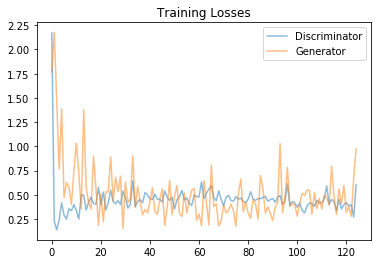

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training


In [24]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [25]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

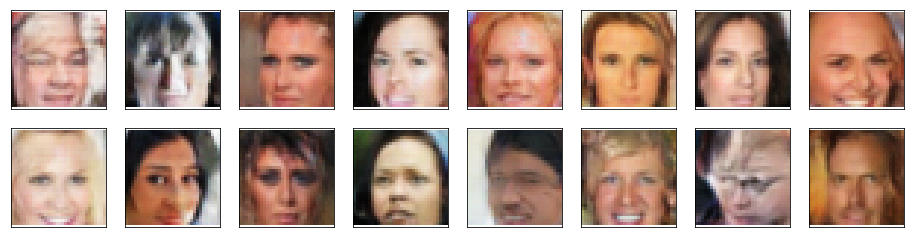

In [26]:
_ = view_samples(-1, samples)


Consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


### How might you improve this model?

1. I would have got more quality if I had increased the image size.
2. I'm pretty sure that It will improve much if I keep training for 50 or 100 epochs, but unfortunately, I haven't had enough resources.
3. I could change the learning rate, but I decided to go for the one introduced in the DCGAN paper.
4. I think changing the learning rate between training (LR Scheduling) would help a lot.